# Исследвание по выбору локации бурения скважины для нефтедобывающей компании

## Описание проекта

**Заказчик**: добывающая компания «ГлавРосГосНефть».

**Данные**: пробы нефти в трёх регионах: в каждом 10 000 месторождений 

**Описание данных**:

Признаки - характеристики для скважин: 
    
    id - id — уникальный идентификатор скважины;
    f0, f1, f2 — показатели качества нефти в пробе;
    product — объём запасов нефти в скважине (тыс. баррелей).

**Дополнительная информация**:

Алгоритм выбора локации:

1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений (требуется выбрать 200 лучших точек для разработки);
4. Определяют регион с максимальной суммарной прибылью отобранных скважин (и вероятностью убытков меньше 2.5%).

**Бизнес-цель**: выбор локации для буреня новой скважины.

**Задача**: определение региона, где добыча принесёт наибольшую прибыль.

**Метрика**: RMSE.

**Ограничения**:

    Следует учитывать, что в реальных условиях можно будет исследовать только по 500 скважин в каждом регионе.
    Можно использовать только модель линейной регрессии.
    Все признаки являются важными.
    
**Параметры для расчета экономических показателей**:

    Бюджет на разработку скважин в регионе — 10 млрд рублей.
    Один баррель сырья приносит 450 рублей дохода.
    Доход с каждой единицы продукта составляет 450 тыс. рублей.    

## Анализ общей информации

Установим библиотеки, которых нет на сервере

In [1]:
# Библиотека pandas-profiling не всегда устанавливается стабильно, поэтому принудительно зададим стабильные версии
!pip install pandas_profiling==1.4.1 -q
!pip install pandas==0.25.3 -q

Импортируем библиотеки, с помощью которых будем обрабатывать данные

In [2]:
# Игнорирование предупреждений об ошибках
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

# EDA анализ 
import pandas_profiling

# Работа с данными
import numpy as np
import pandas as pd
from scipy import stats as st
from datetime import datetime
import time

# Визуализация данных
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# Предобработка
from sklearn.preprocessing import StandardScaler #масштабирование
from sklearn.model_selection import train_test_split #разделение на выборки

# Модели
from sklearn.linear_model import LinearRegression

# Подбор гиперпараметров и лучшей модели
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

# Метрики
from sklearn.metrics import mean_squared_error

# Настройки для печати нескольких выводов данных в одной ячейке
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Установка настроек для отображения всех колонок при печати
pd.set_option('display.max_columns', None)

# Создадим константы для ключевых значений для дальнейших расчётов
SEED = 42
BUDGET = 10000000000
NUMBER_OF_POINTS = 500
TOP = 200
PRICE_ONE_BAR = 450

Блок самописных функций используемых в проекте

In [3]:
def get_info(df_dict, scatterplot=False, duplicated=False, volume_prod=False, distr=False, frame_shape=False):
    
    for key, value in df_dict.items():
        if scatterplot:
            print('График scatterplot для набора данных: '+ key)
            c = sns.pairplot(value, size = 2.5)
            plt.show();
        
        if duplicated:
            list_to_drop = value[value['id'].duplicated()]['id'].tolist()
            print('Анализ набора данных ' + key)
            for id_ in list_to_drop:
                print(value.query('id == @id_'))
                break
            print('------------------------------------------------------')
        
        if volume_prod:
            print('Анализ набора данных ' + key)
            print("Количество скважин с запасом нефти менее 1 барреля: ", len(value.query('product < 1')))
            print('------------------------------------------------------')
            
        if distr:
            sns.distplot(value['product'], label=key)
            plt.legend()
            
        if frame_shape:
            print(f"Размер выборок {key}: features {value[0].shape}, target {value[1].shape}")

def scaling(features_train, features_valid):
    col = features_train.columns
    scaler = StandardScaler()
    scaler.fit(features_train[col])
    features_train[col] = scaler.transform(features_train[col])
    features_valid[col] = scaler.transform(features_valid[col])
    
    return features_train, features_valid
            
def prepare_data(df):
    
    # удалим признак id и разделим данные на выборки
    features = df.drop(['product', 'id'], axis=1)
    target = df['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=42)
    
    
    frame_dict = {'train': [features_train, target_train],
                  'valid': [features_valid, target_valid]}
    
    get_info(frame_dict, frame_shape=True)
    
    # применим масштабирование
    features_train, features_valid = scaling(features_train, features_valid)
        
    return frame_dict

def get_predictions(prepare_data_dict):
    
    model = LinearRegression()
    model.fit(prepare_data_dict['train'][0], prepare_data_dict['train'][1])
    
    predictions_valid = model.predict(prepare_data_dict['valid'][0])
    target_valid = prepare_data_dict['valid'][1].copy().reset_index(drop=True)
    taget_predict_valid = pd.concat([target_valid, pd.Series(predictions_valid)], axis=1)
    
    taget_predict_valid.columns = ['true_answers', 'predict_answers']
    
    rmse = mean_squared_error(prepare_data_dict['valid'][1], predictions_valid) ** 0.5
    
    print('---------------------')
    print('Cредний запас предсказанного запаса сырья: ', round(predictions_valid.mean(), 2))
    print('Значение метрики RMSE на валидационном наборе: ', round(rmse, 2))
    print('-----------------------------------------------')
    
    return taget_predict_valid

def revenue(target, probabilities, count):
    '''
    Функция для расчёта прибыли
    1. Принимает на вход:
    - правильные ответы 
    - предсказания модели на валидационном наборе,
    - количество значений для отбора
    2. Сортирует предсказания в порядке убывания
    3. По индексам отсортираванных значений для отбора(count), отбирает правильные ответы
    для отобранных значенний считается прибыль для каждой скважины
    '''
    
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    stat = [selected.min(), selected.mean(), selected.max()]
    return stat, (profit_one_product * selected.sum()) - BUDGET

def calculation(taget_predict_valid, df_name):
    
    '''
    Функция для расчета основных экономических показателей
    1. Принимает на вход:
    - набор данных с правильными ответами и предсказаниями модели на валидационном наборе
    2. C помощью техники Bootstrap на 1000 выборок, осуществляет отбор 500 значений 
    для имитации реального отбора скважин для анализа
    3. Отобранные значения передаются в функцию revenue для выбора 200 лучших скважин и расчёта прибыли
    4. Расчитвывает:
    - среднюю выручку (по результатм использования техники Bootstrap), 
    - 95%-ый доверительный интервал 
    - вероятность убыточного риска
    '''
    
    state = np.random.RandomState(12345)
    statistic = []
    values = []
    for i in range(1000):
        target_subsample = taget_predict_valid['true_answers'].sample(n=NUMBER_OF_POINTS, replace=True, random_state=state)
        probs_subsample = taget_predict_valid['predict_answers'][target_subsample.index]
        stat, val = revenue(target_subsample, probs_subsample, TOP)
        statistic.append(stat)
        values.append(val)
        
    values = pd.Series(values)
    statistic = pd.DataFrame(statistic, columns=['min', 'mean', 'max'])
    print('Минимальное количество запаса нефти в рассматриваемых к разработке скважинах: ', round(statistic['min'].min(),2)) 
    print('Среднее количество запаса нефти в рассматриваемых к разработке скважинах: ', round(statistic['mean'].mean(),2)) 
    print('Максимальное количество запаса нефти в рассматриваемых к разработке скважинах: ', round(statistic['max'].max(),2))
        
    mean = values.mean()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    risk_persent = (values<0).mean()

    print('Начало и конец 95%-го доверительного интервала:', round(lower,2), round(upper,2))
    print("Средняя прибыль:", round(mean, 2))
    print("Риск убыточности: {:.1%}".format(risk_persent))
    print("------------------------------")
    
    sns.distplot(values, label=df_name)
    plt.legend(title="Bootstrap distribution")

Считываем данные

In [4]:
l = locals()
df_dict = {}
for name in ['geo_data_0', 'geo_data_1', 'geo_data_2']:
    try: 
        l[name] = pd.read_csv(f'datasets\\{name}.csv')
    except:
        print(f'Файл {name}.csv не найден и будет скачиваться по сети.')
        l[name] = pd.read_csv(f'https://code.s3.yandex.net/datasets/{name}.csv') 
    df_dict[name] = l[name]   

Файл geo_data_0.csv не найден и будет скачиваться по сети.
Файл geo_data_1.csv не найден и будет скачиваться по сети.
Файл geo_data_2.csv не найден и будет скачиваться по сети.


Запусим библиотеку pandas_profiling и посмотрим как выглядят статистики

In [5]:
for key, value in df_dict.items():
    print('Анализ набора данных ' + key)
    pandas_profiling.ProfileReport(value)

Анализ набора данных geo_data_0


Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Анализ набора данных geo_data_1


Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,1


Анализ набора данных geo_data_2


Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Инструмент pandas_profiling позволяет изучить основную информацию о значениях и статистиках по признакам. Автоматический анализатор позволяет быстро получить информацию о типах данных, распределениях, наличиях пропусков и дублей в наборе данных. Так же можно увидеть информацию о корреляции между признаками или признаками и целевой переменной. Данный инструмент не позволяет ответить на все вопросы о наших данных, но помогает довольно быстро оценить основные проблемы, присутствующие в данных и определиться с инструментами для более детального анализа.

Анализ текущих данных в pandas_profiling показал:
- отсутствие пропусков, 
- дубли в признаке id, 
- высокую корреляцию (0.99) признака `f2` с целевым признаковм `product` в наборе данных geo_data_1

Требуется дальнейший анализ и принятие решения по данным вопросам.

Построим график типа scatterplot

График scatterplot для набора данных: geo_data_0


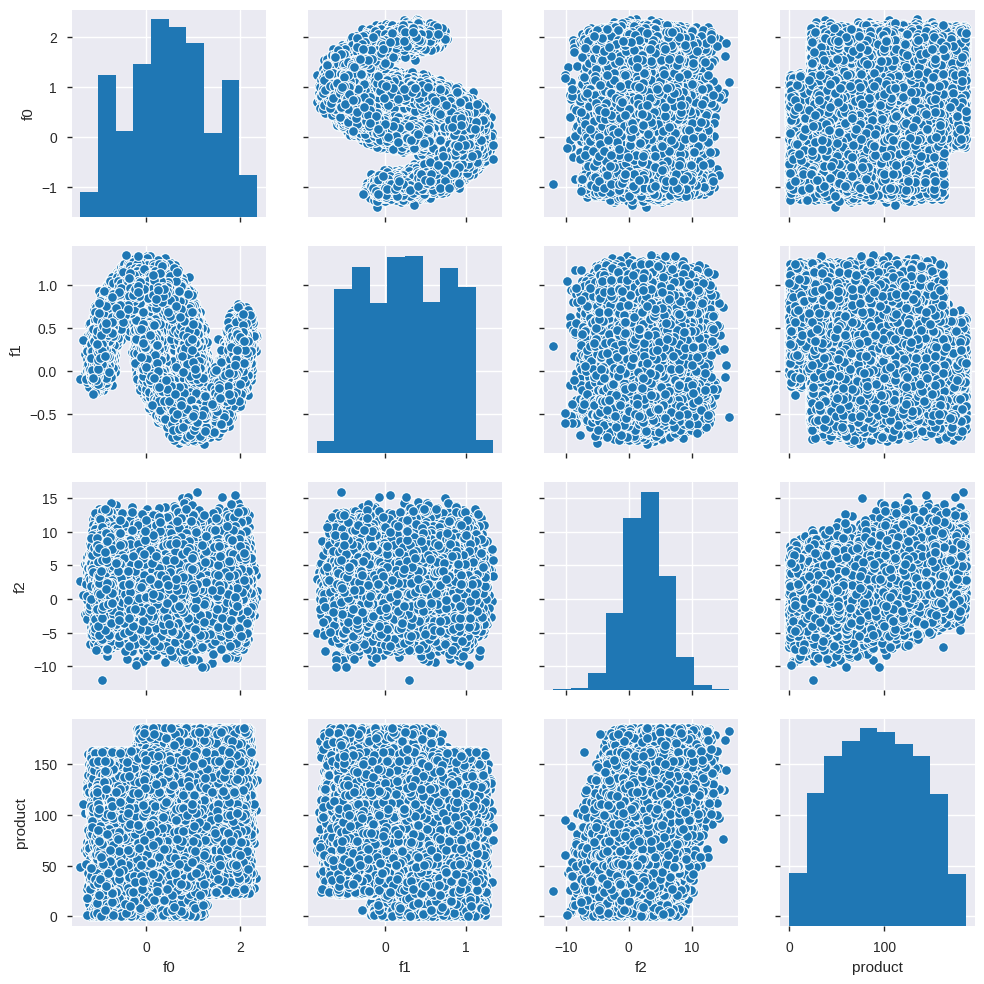

График scatterplot для набора данных: geo_data_1


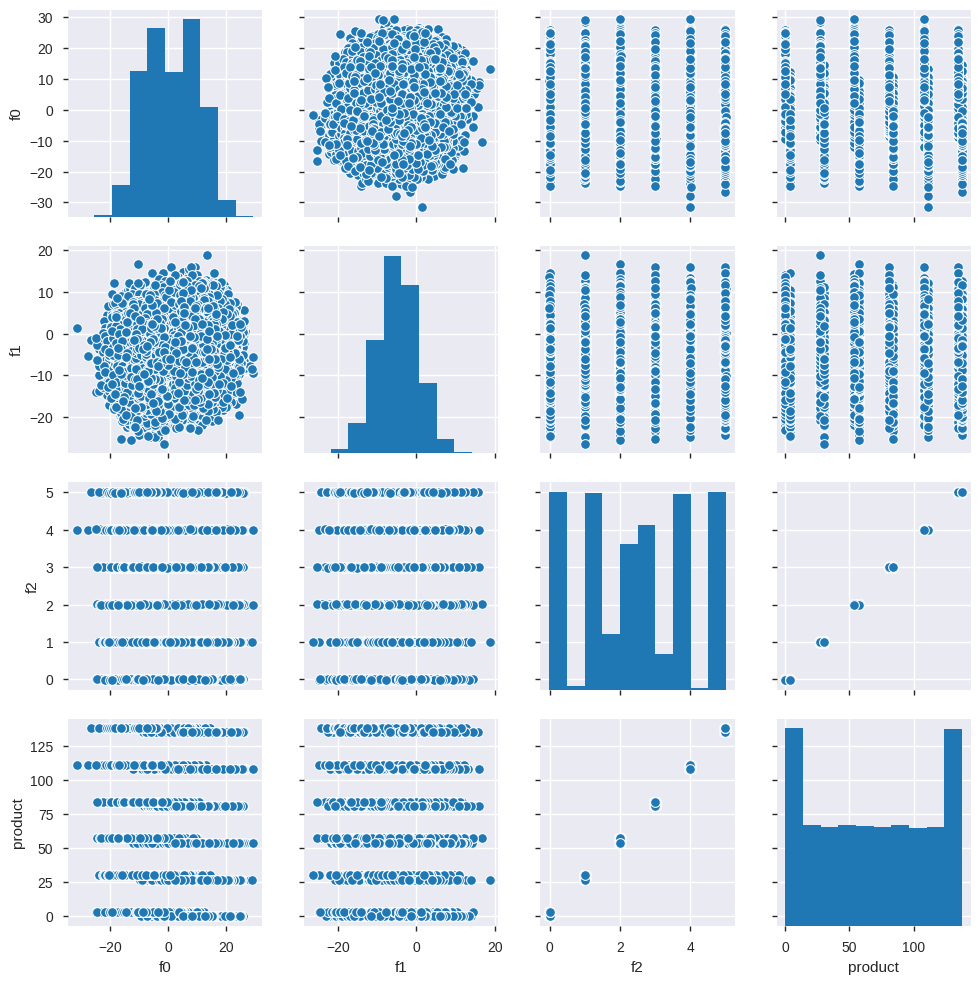

График scatterplot для набора данных: geo_data_2


In [ ]:
get_info(df_dict, scatterplot=True)

Проверим значения с дублями по одному из идентификаторов каждого региона

In [ ]:
get_info(df_dict, duplicated=True)

На основании этой нформации сложно понять реальную причину задвоения id. Это могут быть как повторные исследования одний и той же скважины в разные пероды времени, так и различные скважины, id которых совпали случайным образом.

Т.к. у нас нет оснований сомневаться в коректности измерений, а признак id сам по себе не информативен и мжет быть вреден для модели, удалим его.

Посмотрим на значения с количеством нефти менее 1 барреля на скважину по всем регионам

In [ ]:
get_info(df_dict, volume_prod=True)

Проанализируем распределения целевого признака

In [ ]:
get_info(df_dict, distr=True)

Видно что для региона geo_data_1, распределнение запасов в месторождениях принципиально отличается от распределений в geo_data_0 и geo_data_2 - имеются ярко выраженные пики. Предположительо это скважины, где сконцетрированы месторождения. Одновременно с этим регионы geo_data_0 и geo_data_2 похожи и по количеству бедных скважин, а регион geo_data_1 отличается сущственно большим их количеством.

**Вывод**

 - преобразование типов не требуется 
 - пропуски отсутствуют
 - выявлено наличие дублей в колонке `id`, но при этом значения в других колонках различны. Т.к.  не удалось выявить причин данного явления, а количество случаев не критично, принято решение оставить строки, но удалить колонку `id`.
 - признаки `f0`, `f1`, `f2` имеют различный разброс значений - требуется нормализация.

В наборе данных `geo_data_1` высокий уровень корреляции между признаком `f2` и целевой переменной. Но, т.к. по условию задачи все признаки важны, удалять их нельзя.

Анализ количества продукта по регионам выявил, что скважины в регионе `geo_data_1` в среднем беднее, чем в двух других регионах - выявлено большое количество скважин с околонулевым запасом нефти. 

## Предобработка данных и моделирование

Сделаем следующие шаги:
    - разбиение данных на выборки
    - масштабирование
    - обучение модели LinearRegression
    - получение предсказаний от обученной модели

In [ ]:
results_dict = {}
for key, value in df_dict.items():
    print('Обработаем набор данных: ' + key)
    prepare_data_dict = prepare_data(value)
    taget_predict_valid = get_predictions(prepare_data_dict)
    results_dict[key] = taget_predict_valid

**Вывод**

- удалены строки с дублями в колонке `id`    
- данные разделены на обучающий и валидационный наборы  
- произведена нормализация данных  
- для каждого региона построена модель Линейной регрессии

На наборе данных `geo_data_1` закономерно сравнительно лучшее качество по метрике RMSE - предполагаю, что такой результат обусловлен наличием признака, который практически полностью идентичен целевой переменной. Качество метрики в двух остальных регионах практически одинаково. 

Следует отметить, что несмотря на хорошие значения метрики, средний запас предсказанного объема сырья по региону `geo_data_1` имеет самое низкое значение.

## Расчет основных экономических показателей

### Подготовка к расчёту прибыли

Рассчитаем зависимые показатели Бюджет на одну скважину и Стоимость одной единицы продукта

In [ ]:
budget_one_point = BUDGET / TOP
profit_one_product = PRICE_ONE_BAR * 1000

Посчитаем минимальное среднее количество продукта в месторождениях региона, достаточное для разработки.
Рассчитаем достаточный объём сырья для безубыточной разработки одной новой скважины

In [ ]:
normal_product = round(BUDGET/profit_one_product/200, 2)
print('Объём сырья для безубыточной разработки одной новой скважины: ', normal_product)
print('')
# Сравним полученный объём сырья со средним запасом в каждом регионе
for key, value in df_dict.items():
    print('Обработаем набор данных: ' + key)
    print('Количество скважин в регионе с запасом нефти менее 111 тыс. баррелей: ', len(value.query('product<111')))
    if value['product'].mean() >= normal_product:
        print('В данном регионе достаточное количество продукта для разработки.') 
        print('Средний запас нефти в скважинах по региону: ', round(value.query('product!=0')['product'].mean(), 0))
    else:
        print('В данном регионе недостаточное количество продукта для разработки.')
        print('Средний запас нефти в скважинах по региону: ', round(value.query('product!=0')['product'].mean(), 0))
    print('-------------------------------------------------')

Напишем функцию revenue для расчёта прибыли (код представлен в блоке с функциями в начале проекта). 
В фунцию будем передавать правильные ответы и предсказания модели на валидационном наборе, а так же количество значений для отбора. Далее происходит сортировка предсказаний в порядке убывания. По индексам отсортираванных значений для отбора(count), отбираются правильные ответы и для отобранных значенний считается прибыль для каждой скважины.

Напишем функцию calculation для расчета основных экономических показателей  (код представлен в блоке с функциями в начале проекта). В фунцию будем передавать набор данных с правильными ответами и предсказаниями модели на валидационном наборе. С помощью техники Bootstrap на 1000 выборок, осуществляем отбор 500 значений для имитации реального отбора скважин для анализа. Отобранные значения передаются в функцию revenue для выбора 200 лучших скважин и расчёта прибыли. Далее расчитвывается средняя выручка (по результатм использования техники Bootstrap), 95%-ый доверительный интервал и вероятность убыточного риска.

### Расчёт прибыли и рисков 

Осуществим вызов функции calculation в цикле для раждого региона

In [ ]:
for key, value in results_dict.items():
    print('Обработаем набор данных: ' + key)
    calculation(value, key)

**Вывод**

- вычислены и зафиксированы показатели требуемые для расчета экономической эффективности работы модели
- реализован бизнес-алгоритм по выбору 200 наиболее рентабельных скважин
- с помощью техники Bootstrap рассчитана средняя выручка, 95%-ый доверительный интервал и вероятность убыточного риска

## Общий вывод

Проанализированы предоставленные наборы исторических данных добывающей компании «ГлавРосГосНефть» по регионам добычи нефти.  

В данных были выявлены следующие особенности:

- наличие дублей в колонке `id`, но при этом значения в других колонках различны  
- наличие высокого уровеня корреляции между признаком `f2` и целевой переменной `product` 
- большое количество скважин с низким содержанием запасов сырья 

Для каждого региона построена модель Линейной регрессии.
Для региона `geo_data_1` модель показала наилучшее значение качетсва по метрике RMSE. Качество метрики в двух остальных регионах практически одинаково хуже в сравнении с регионом `geo_data_1`. 

Реализован бизнес-алгоритм по выбору 200 наиболее рентабельных скважин, среди отобранных 500, по которым бизнес-заказчик может провести анализ. 
С помощью техники Bootstrap рассчитана средняя выручка, 95%-ый доверительный интервал и вероятность убыточного риска.  

Анализ показателей убыточности показал, что добыча в регионе `geo_data_1` будет безубыточна со средней выручкой не ниже выделенного бюджета. Данный регион (набор данных `geo_data_1`) предлагается к выбору для разработки скважин. 